In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/home/raroog/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class TrialSolution(tf.keras.models.Model):
  def __init__(self, ODE_number, conditions, n_i, n_h, n_o=1, activation='sigmoid', equation_type='ODE'):
    super(TrialSolution, self).__init__()
    self.ODE_number = ODE_number
    self.n_i = n_i
    self.n_h = n_h
    self.n_o = n_o
    self.conditions = conditions
    self.hidden_layers = []
    for i in range(self.ODE_number):
      self.hidden_layers.append(tf.keras.layers.Dense(units=self.n_h, activation=activation))    
    self.output_layers = []
    for i in range(self.ODE_number):
       self.output_layers.append(tf.keras.layers.Dense(units=self.n_o, activation='linear'))
    
  def call(self, X):
    X = tf.convert_to_tensor(X)
    responses = []
    for i in range(self.ODE_number):
      resp = self.hidden_layers[i](X)
      responses.append(self.output_layers[i](resp))    
    
    for ode in range(self.ODE_number):
      boundary_value = tf.constant(0., dtype='float64', shape=responses[ode].get_shape())

      for condition in self.conditions:
        if condition['ode_number'] == ode+1:
          vanishing = tf.constant(1., dtype='float64', shape=responses[ode].get_shape())
          temp_bc = 0
          if condition['type'] == 'dirichlet':
            temp_bc = tf.reshape(condition['function'](X), shape=boundary_value.shape)           
            for vanisher in self.conditions:
              if (vanisher['ode_number'] == ode+1
                  and vanisher['variable'] != condition['variable']
                  and vanisher['value'] != condition['value']):
                if vanisher['type'] == 'dirichlet':
                  vanishing *= (X[:, vanisher['variable']]
                                            - tf.constant(vanisher['value'], dtype='float64', shape=boundary_value.shape))
                elif vanisher['type'] == 'neumann':
                  vanishing *= (X[:, vanisher['variable']]
                                            - tf.constant(vanisher['value'], dtype='float64', shape=boundary_value.shape))
            boundary_value += temp_bc * vanishing
            responses[ode] *= (tf.constant(condition['value'], dtype='float64', shape=boundary_value.shape)
                         - tf.reshape(X[:, condition['variable']], shape=boundary_value.shape))
          elif condition['type'] == 'neumann':
            temp_bc = (tf.reshape(condition['function'](X), shape=boundary_value.shape)
                       * tf.reshape(X[:, condition['variable']], shape=boundary_value.shape))
            boundary_value = temp_bc
            responses[ode] *= (tf.constant(condition['value'], dtype='float64', shape=boundary_value.shape)
                         - tf.reshape(X[:, condition['variable']], shape=boundary_value.shape))  
      responses[ode] += boundary_value
    response = tf.concat(responses, axis=1)
    return responses

In [3]:
inits = [{'variable':0, 'value':0, 'type':'dirichlet', 'ode_number':1,
        'function':lambda X: tf.constant(0., dtype='float64', shape=(X.shape[0],1))},
        {'variable':0, 'value':0, 'type':'dirichlet', 'ode_number':2,
        'function':lambda X: tf.constant(1., dtype='float64', shape=(X.shape[0],1))}]

In [4]:
Xs = np.arange(0, 3, 0.2) + 1e-6
Xs = Xs.reshape(-1,1)

In [5]:
ts = TrialSolution(conditions=inits, n_i=1, n_h=10, n_o=1, ODE_number=2)

In [6]:
def diff_loss(network, inputs):
  with tf.GradientTape() as tape1:
    inputs = tf.convert_to_tensor(inputs)
    tape1.watch(inputs)
    response1 = network(inputs)[0]
  grads1 = tape1.gradient(response1, inputs)  
  with tf.GradientTape() as tape2:
    inputs = tf.convert_to_tensor(inputs)
    tape2.watch(inputs)
    response2 = network(inputs)[1]
  grads2 = tape2.gradient(response2, inputs)
  loss1 = (grads1 - tf.cos(inputs) - response1**2 - response2 + tf.constant(1, dtype='float64')
           + inputs ** 2 + tf.sin(inputs) ** 2)
  loss2 = (grads2 - tf.constant(2., dtype='float64') * inputs 
           + (tf.constant(1., dtype='float64') + inputs**2) * tf.sin(inputs) - response1*response2)
  loss = tf.square(loss1) + tf.square(loss2)
  return loss

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
train_loss = tf.keras.metrics.Mean('train')

In [8]:
@tf.function
def train_step(X):
  with tf.GradientTape() as tape:
    loss = diff_loss(ts, X)
  gradients = tape.gradient(loss, ts.trainable_variables)
  optimizer.apply_gradients(zip(gradients, ts.trainable_variables))
  train_loss(loss)

In [9]:
ts(tf.convert_to_tensor(Xs))

[<tf.Tensor: id=146, shape=(15, 1), dtype=float64, numpy=
 array([[-5.26055436e-07],
        [-1.09794297e-01],
        [-2.28671059e-01],
        [-3.56388780e-01],
        [-4.92560073e-01],
        [-6.36674430e-01],
        [-7.88126085e-01],
        [-9.46244900e-01],
        [-1.11032762e+00],
        [-1.27966716e+00],
        [-1.45357808e+00],
        [-1.63141719e+00],
        [-1.81259862e+00],
        [-1.99660359e+00],
        [-2.18298515e+00]])>,
 <tf.Tensor: id=171, shape=(15, 1), dtype=float64, numpy=
 array([[1.00000054],
        [1.10954727],
        [1.22128548],
        [1.33531606],
        [1.45179758],
        [1.57093307],
        [1.6929536 ],
        [1.81810037],
        [1.94660698],
        [2.07868341],
        [2.21450267],
        [2.35419095],
        [2.49782138],
        [2.6454113 ],
        [2.7969227 ]])>]

0.33320162


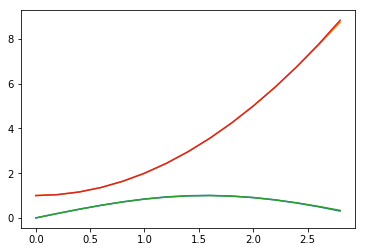

0.17800456


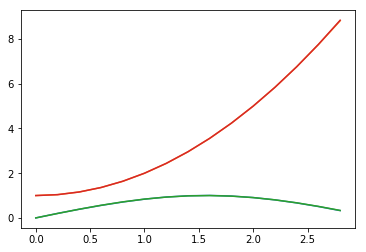

0.12396647


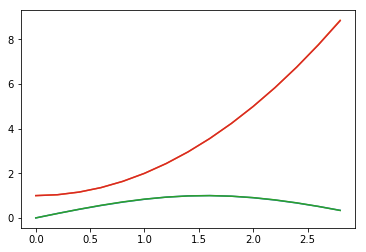

0.09652396


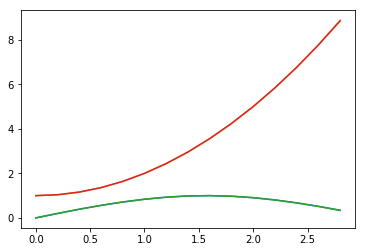

0.07957279


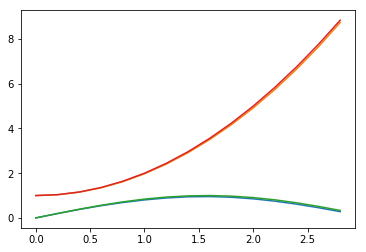

0.06800973


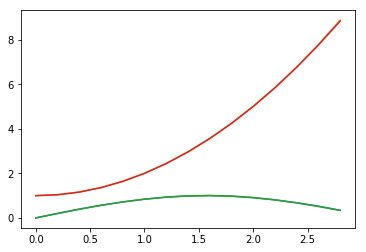

0.059629705


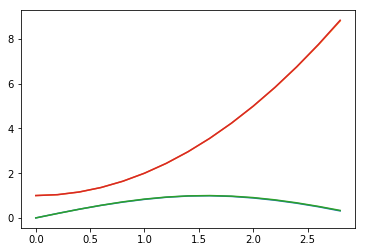

0.053147763


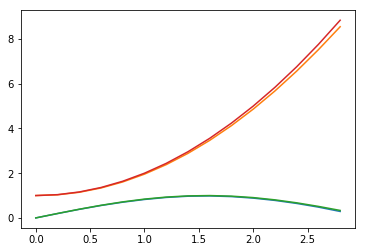

0.048135247


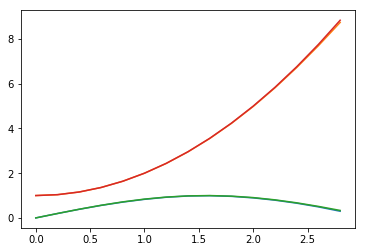

0.044001203


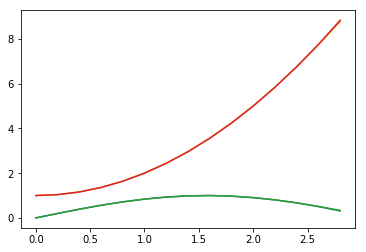

0.040576484


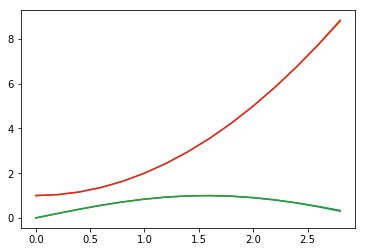

0.037716877


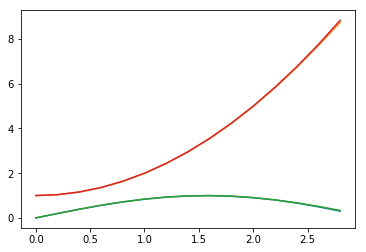

0.03525801


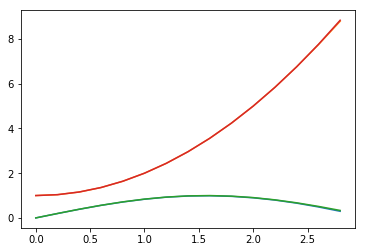

0.033168856


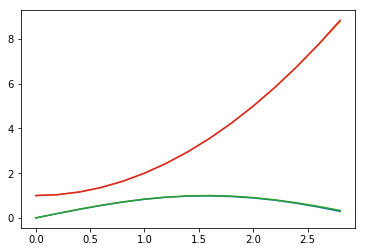

0.031336337


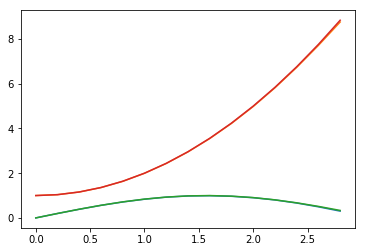

0.029751172


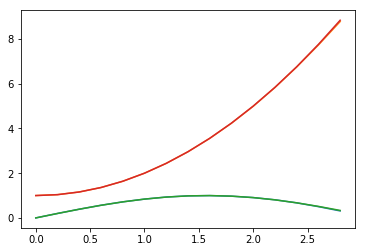

0.028331798


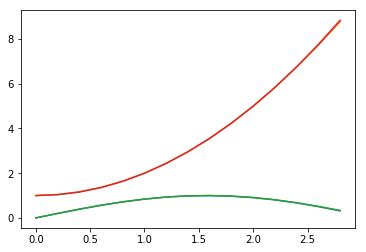

0.027077977


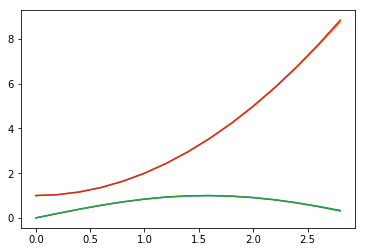

0.025960939


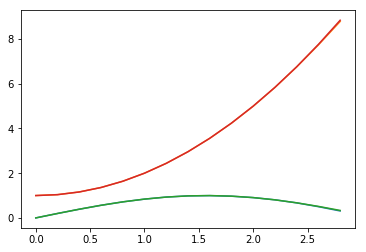

0.024939703


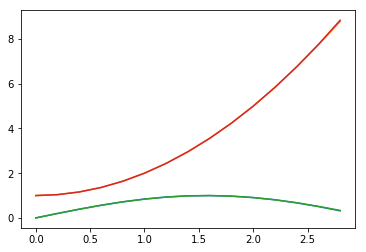

0.024031378


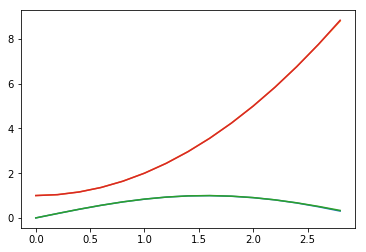

0.023204455


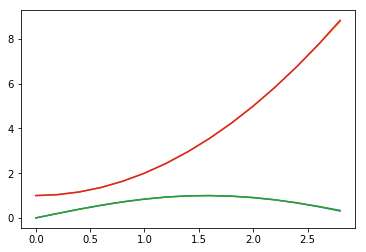

0.022437735


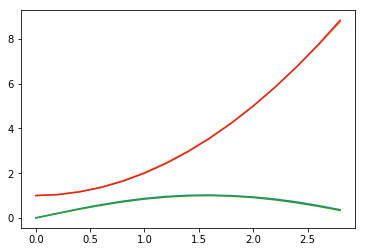

0.021762216


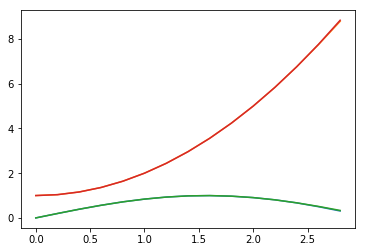

0.02110281


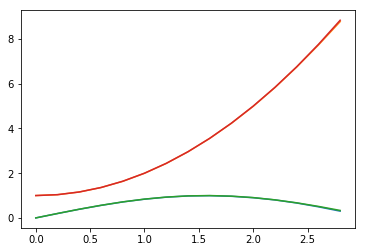

0.020505669


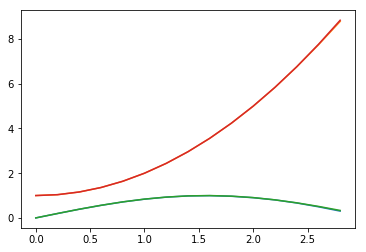

0.019953486


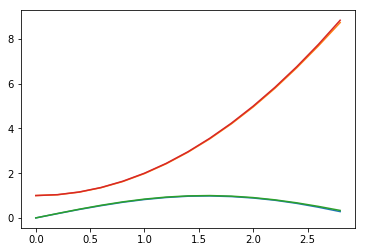

0.019453079


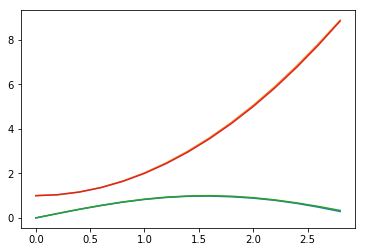

0.018966898


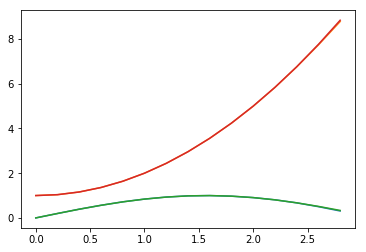

0.018531486


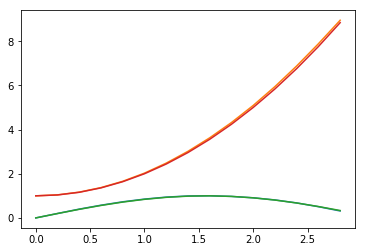

0.018113988


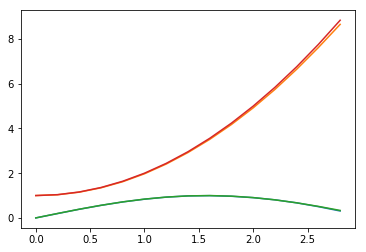

0.017726399


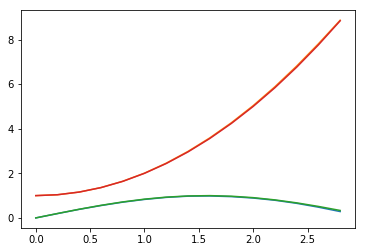

0.017361745


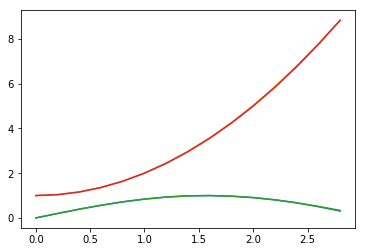

0.017018037


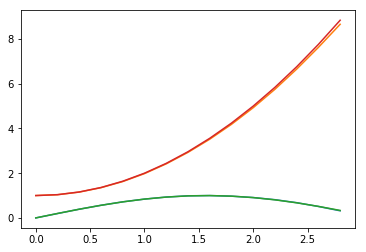

0.0166941


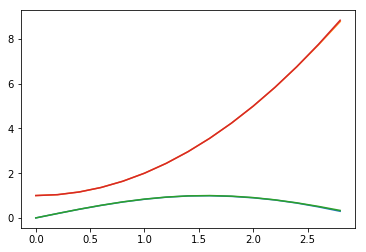

0.01638392


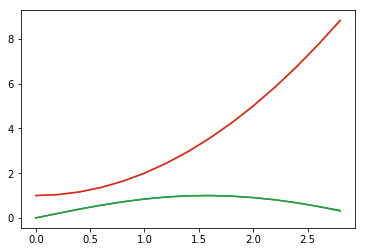

0.016088039


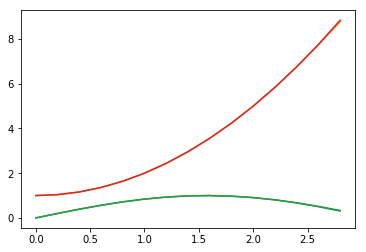

0.015802791


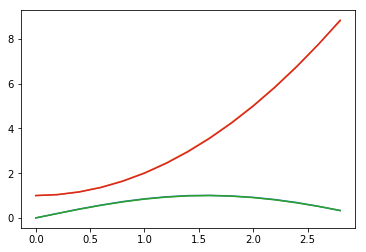

0.015542635


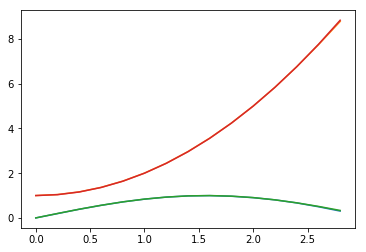

0.015294925


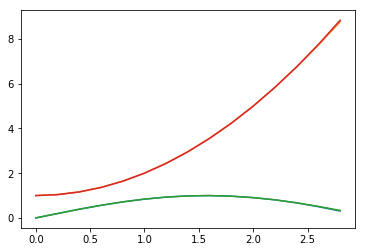

0.015053098


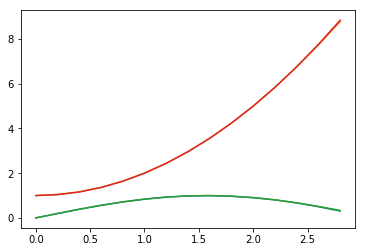

0.014830206


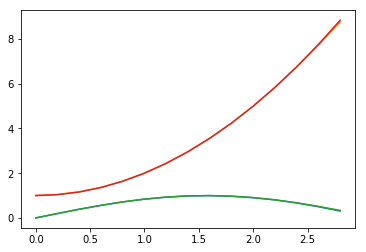

0.014612693


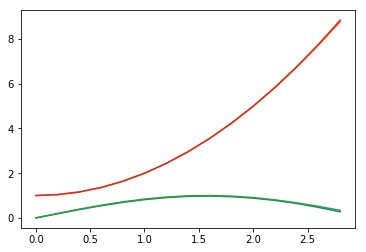

0.014408841


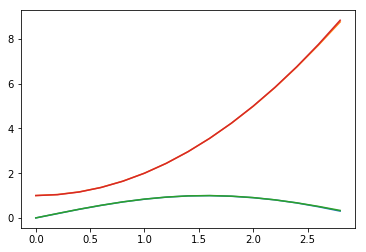

0.014210548


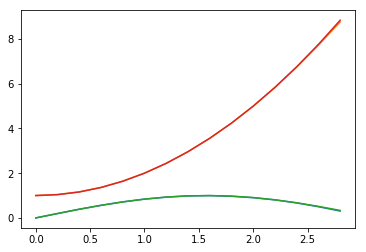

0.014019197


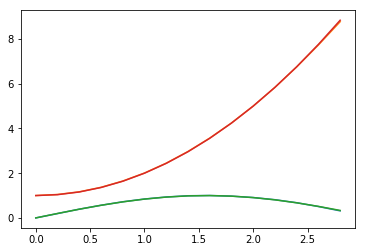

0.013845841


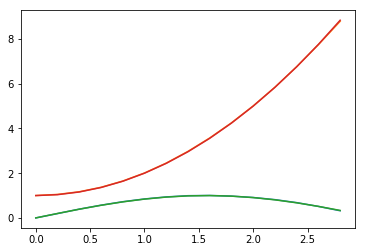

0.013671549


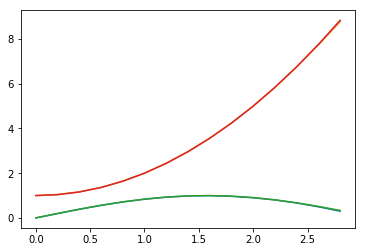

0.013502748


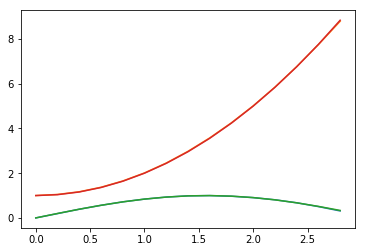

0.013341548


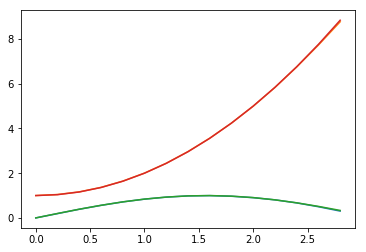

0.013195138


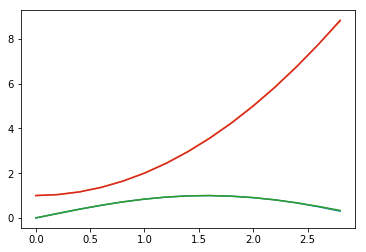

0.0130495215


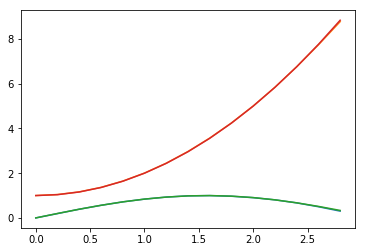

0.012898846


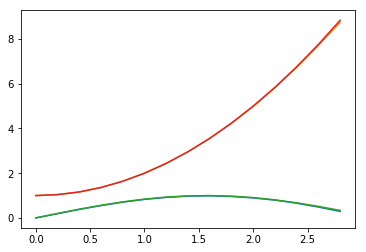

0.012765738


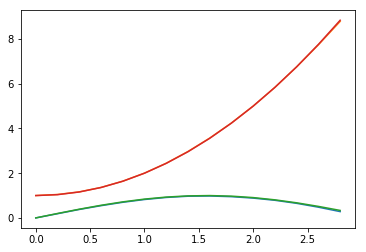

0.012628227


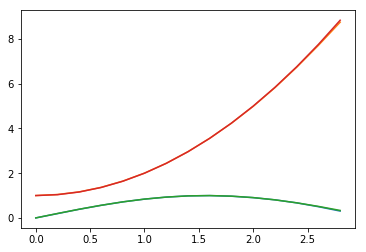

0.012502052


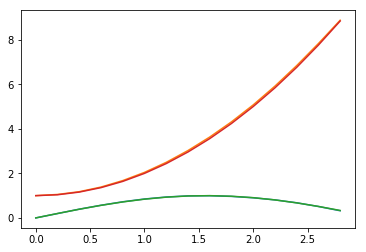

0.012374894


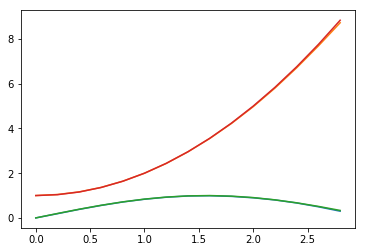

0.012249648


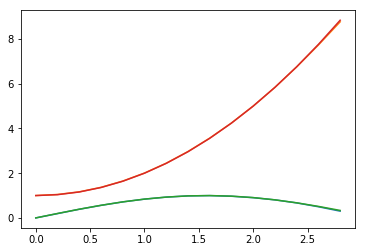

0.012130849


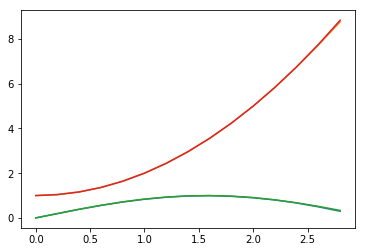

0.01201788


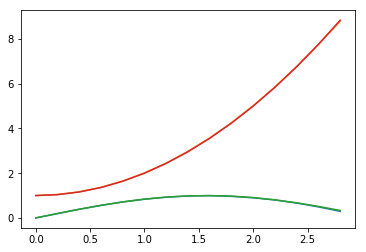

0.011908904


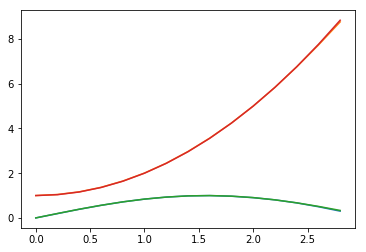

0.0117995115


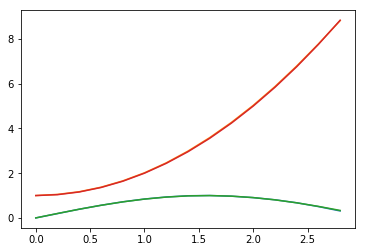

0.011692581


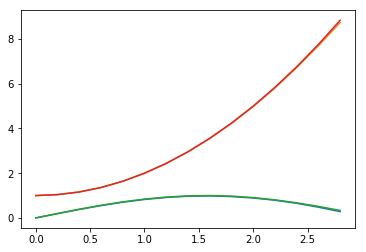

0.0115956245


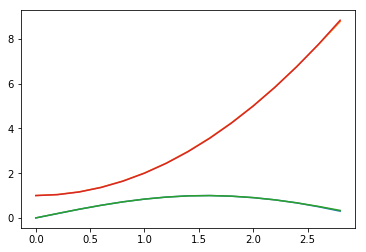

0.01149387


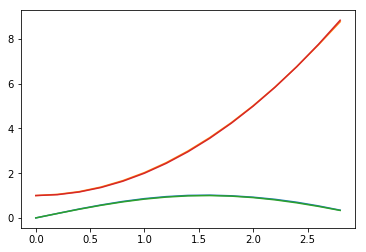

0.011401434


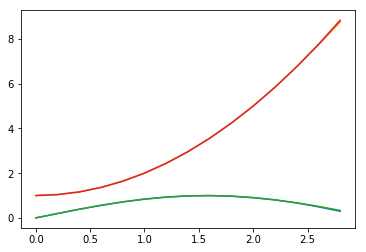

0.011305966


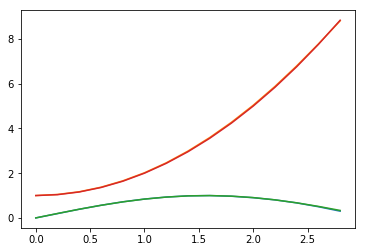

0.011211591


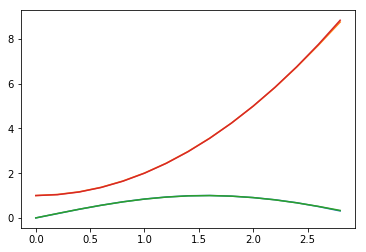

0.011119422


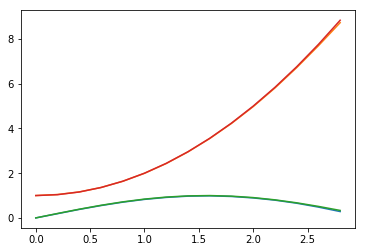

0.011034513


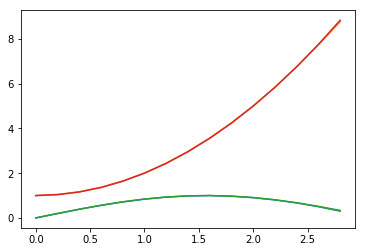

0.0109496005


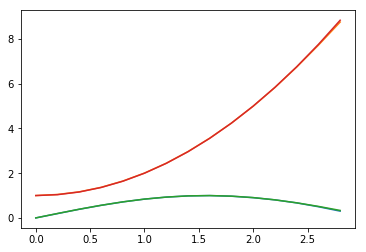

0.010871994


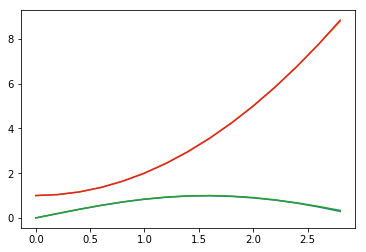

0.0107910475


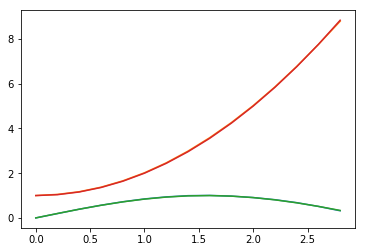

0.010711161


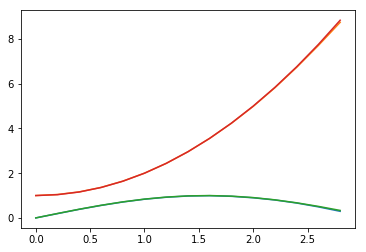

0.010635139


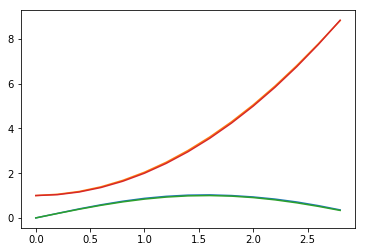

0.01056424


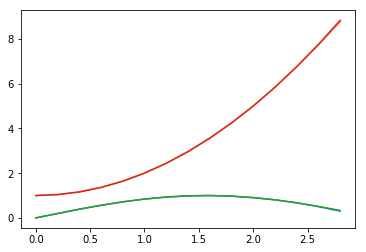

0.010489249


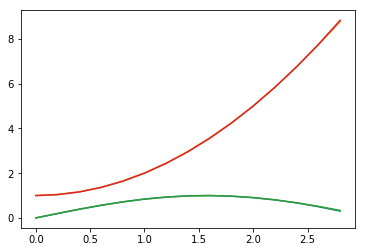

0.010419964


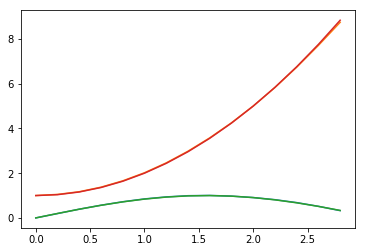

0.010349781


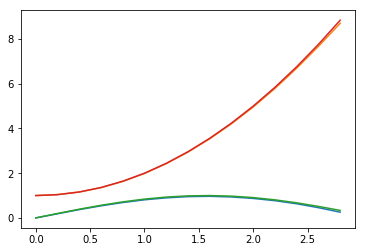

0.010285365


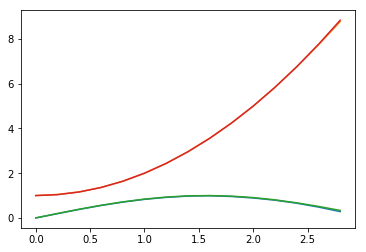

0.01021781


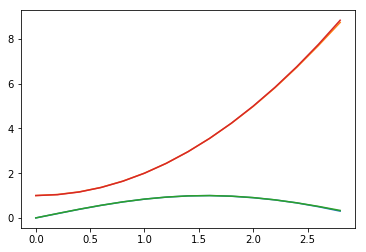

0.010152357


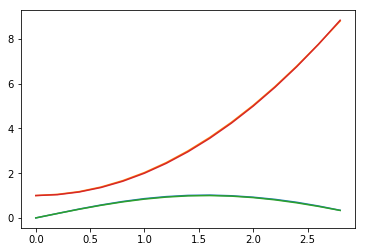

0.010090131


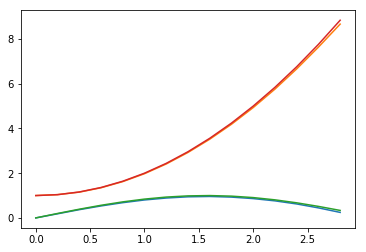

0.010029746


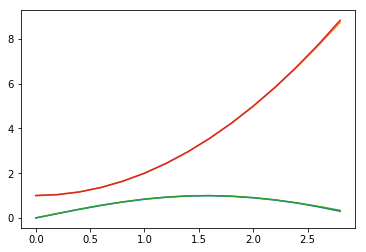

0.009970576


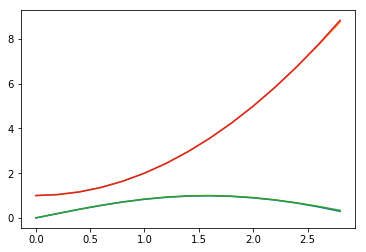

0.009912352


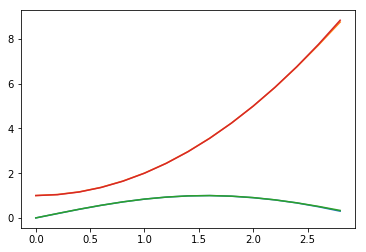

0.009855692


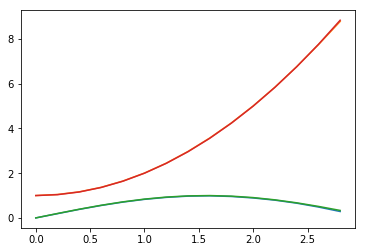

0.009799367


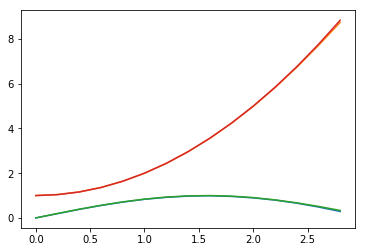

0.009746225


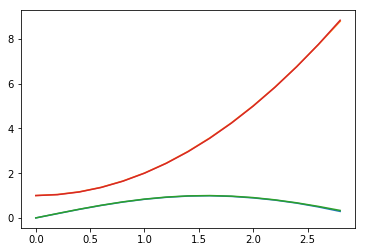

0.009692914


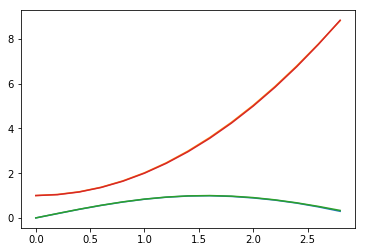

0.009639362


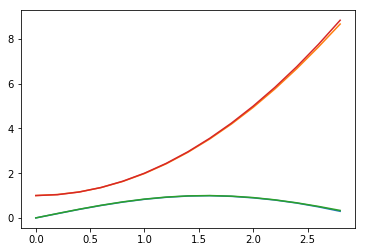

0.009587932


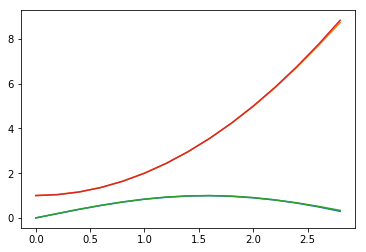

0.009536674


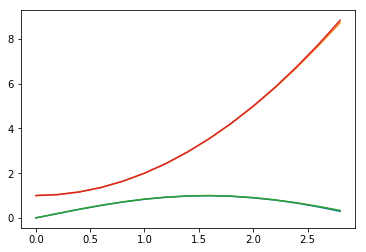

0.009488321


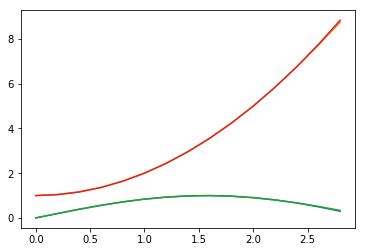

0.009441262


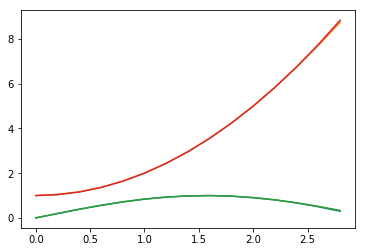

0.009393714


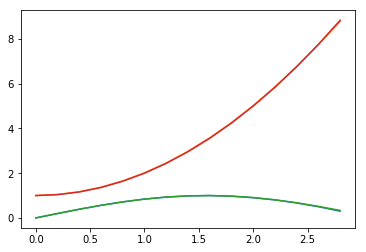

0.009347159


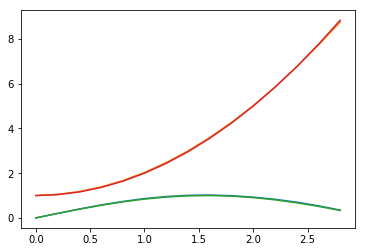

0.009300792


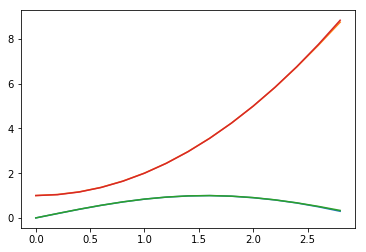

0.009254588


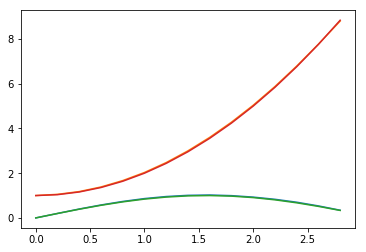

0.009211814


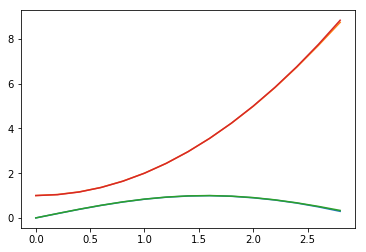

In [10]:
EPOCHS = 100000
test = 0
for epoch in range(EPOCHS):
  train_step(Xs)
  if (epoch+1) % int(EPOCHS/100) == 0:
    print(train_loss.result().numpy())
    pred1 = ts.call(tf.convert_to_tensor(Xs, dtype='float64'))[0].numpy()
    pred2 = ts.call(tf.convert_to_tensor(Xs, dtype='float64'))[1].numpy()
    plt.plot(Xs, pred1, label='prediction 1')
    plt.plot(Xs, pred2, label='prediciton 2')
    plt.plot(Xs, np.sin(Xs), label='true 1')
    plt.plot(Xs, 1+Xs**2, label='true2')
    plt.show()

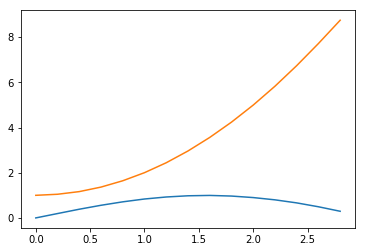

In [11]:
pred1 = ts.call(tf.convert_to_tensor(Xs, dtype='float64'))[0].numpy()
pred2 = ts.call(tf.convert_to_tensor(Xs, dtype='float64'))[1].numpy()
plt.plot(Xs, pred1, label='prediction 1')
plt.plot(Xs, pred2, label='prediciton 2')
# plt.plot(Xs, np.sin(Xs), label='true 1')
# plt.plot(Xs, 1+Xs**2, label='true2')
plt.show()

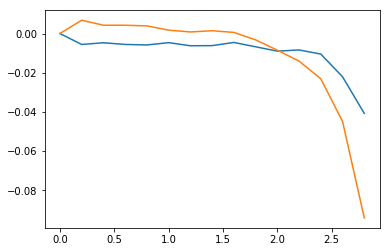

In [12]:
plt.plot(Xs, pred1 - np.sin(Xs), label='diff 1')
plt.plot(Xs, pred2 - (1+Xs**2), label='diff 2')
plt.show()

In [15]:
diff1 = pred1 - np.sin(Xs)
diff2 = pred2 - (1+Xs**2)

In [18]:
print(np.sqrt((diff1**2).mean()))
print(np.sqrt((diff2**2).mean()))

0.013401298405496977
0.028021147218660145
